#  5（选做）模型比较
在同一数数据集上，比较不同聚类方法个性能，通过可视化初评价指标，文字叙述）方式呈现。

## 1. 导入所需的库

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.decomposition import PCA

## 2. 加载 Iris 数据集并进行数据预处理

In [6]:
# 2. 加载Iris数据集
file_path = '/home/aistudio/dataset/01-True/Iris.csv'
data = pd.read_csv(file_path)

# 查看数据集的结构
X = data.iloc[:, :-1].values  # 特征部分
y = data.iloc[:, -1].values  # 标签部分（Iris种类）

- 使用 `.iloc[:, :-1]` 提取所有特征列（最后一列为目标标签，省略）。
- 使用 `.iloc[:, -1]` 提取目标标签（即 `Iris` 的种类标签）。

## 3. 数据标准化

In [7]:
# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- 使用 `StandardScaler` 对数据进行标准化处理，使每个特征的均值为 0，标准差为 1。
- `X_scaled` 存储了标准化后的数据。

## 4. KMeans 聚类

In [8]:
# 4. KMeans聚类
class KMeans:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
    
    def fit(self, X):
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[random_indices]
        
        for i in range(self.max_iters):
            labels = self._assign_labels(X)
            new_centroids = self._compute_centroids(X, labels)
            shift = np.sum((new_centroids - self.centroids) ** 2)
            if shift < self.tol:
                print(f'Converged after {i+1} iterations')
                break
            self.centroids = new_centroids
    
    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _compute_centroids(self, X, labels):
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
        return centroids
    
    def predict(self, X):
        return self._assign_labels(X)
    
    def get_centroids(self):
        return self.centroids

**K-means**:

- `fit()` 方法：训练模型，初始化随机的 `k` 个簇中心，通过迭代更新簇中心，直到收敛或达到最大迭代次数。
- `_assign_labels()` 方法：为每个数据点分配到最近的簇中心。
- `_compute_centroids()` 方法：计算每个簇的新中心点。
- `predict()` 方法：给定数据，预测其簇标签。
- `get_centroids()` 方法：获取当前簇中心。

## 5. GMM 聚类

In [9]:
# 5. GMM聚类
def initialize_gmm(X, k):
    n_samples, n_features = X.shape
    kmeans = SklearnKMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X)
    means = kmeans.cluster_centers_
    covariances = np.array([np.eye(n_features)] * k)
    weights = np.ones(k) / k
    return means, covariances, weights

- `initialize_gmm()` 方法使用 KMeans 算法初始化 GMM 的均值、协方差矩阵和权重。
- 先使用 KMeans 聚类来初始化 GMM 的均值，协方差矩阵初始化为单位矩阵，权重均匀分配。

## 6. DBSCAN 聚类

In [11]:
# 6. DBSCAN聚类
class DBSCAN:
    def __init__(self, epsilon=0.5, min_points=5):
        self.epsilon = epsilon
        self.min_points = min_points
        self.labels_ = None
    
    def fit(self, X):
        n_samples = len(X)
        self.labels_ = np.full(n_samples, -1)
        cluster_id = 0
        visited = np.zeros(n_samples, dtype=bool)
        
        def region_query(i):
            neighbors = []
            for j in range(n_samples):
                if np.linalg.norm(X[i] - X[j]) < self.epsilon:
                    neighbors.append(j)
            return neighbors
        
        def expand_cluster(i, neighbors, cluster_id):
            self.labels_[i] = cluster_id
            queue = neighbors[:]
            while queue:
                j = queue.pop(0)
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= self.min_points:
                        queue.extend(new_neighbors)
                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id
        
        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = region_query(i)
                if len(neighbors) < self.min_points:
                    self.labels_[i] = -1
                else:
                    expand_cluster(i, neighbors, cluster_id)
                    cluster_id += 1

- `fit()` 方法：首先标记所有样本为未访问。然后，对于每个未访问的样本，进行邻域查询，如果样本数大于 `min_points`，则扩展聚类。
- `region_query()` 方法：返回一个样本的邻域。
- `expand_cluster()` 方法：扩展聚类，直到所有密度可达的点都被标记。

## 7. 聚类算法比较

In [12]:
# 7. 聚类算法比较
k = 3  # 选择3个簇
# KMeans
kmeans_model = KMeans(k=k)
kmeans_model.fit(X_scaled)
kmeans_labels = kmeans_model.predict(X_scaled)

# GMM
gmm_model = SklearnGMM(n_components=k)
gmm_labels = gmm_model.fit_predict(X_scaled)

# DBSCAN
dbscan_model = SklearnDBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_scaled)

Converged after 9 iterations


- 选择 3 个簇进行比较。
- 使用手动实现的 KMeans 和 GMM，以及 `sklearn` 的 `DBSCAN` 聚类方法。
- 对每个聚类模型调用 `fit()` 或 `fit_predict()` 进行聚类并得到标签。

## 8. 计算聚类评价指标

In [13]:
# 8. 计算评价指标
def evaluate_clustering(true_labels, pred_labels):
    silhouette = silhouette_score(X_scaled, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return silhouette, nmi, ari

`evaluate_clustering()` 函数计算并返回给定聚类结果的三个评价指标：轮廓系数、NMI和ARI。

In [14]:
# 计算每个聚类方法的评价指标
metrics_kmeans = evaluate_clustering(y, kmeans_labels)
metrics_gmm = evaluate_clustering(y, gmm_labels)
metrics_dbscan = evaluate_clustering(y, dbscan_labels)

## 9. 可视化聚类结果

In [15]:
# 8. 可视化
def plot_clustering(X, labels, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()

`plot_clustering()` 函数使用 PCA 将数据降到二维，并绘制聚类结果的散点图。

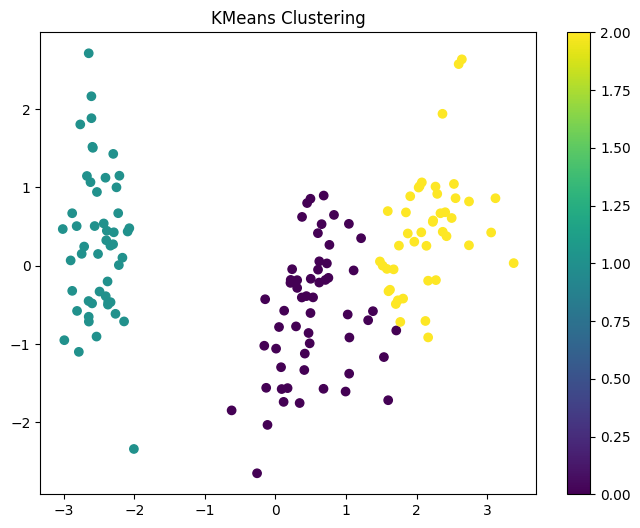

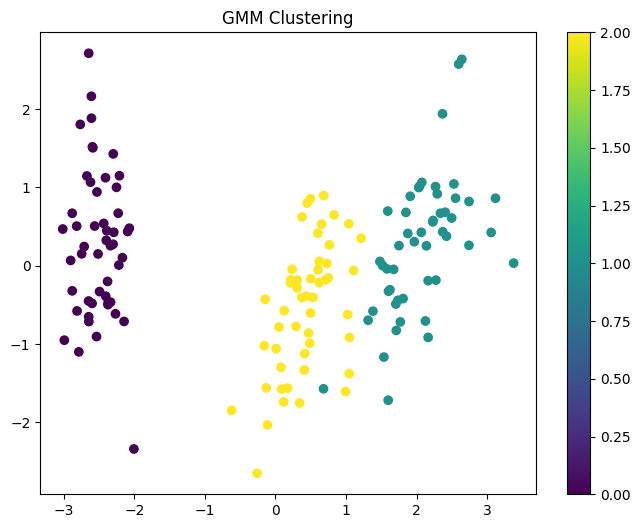

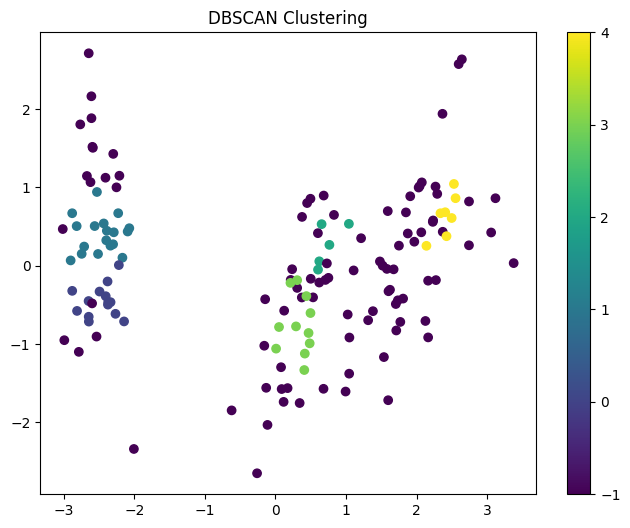

In [16]:
# 聚类结果可视化
plot_clustering(X_scaled, kmeans_labels, 'KMeans Clustering')
plot_clustering(X_scaled, gmm_labels, 'GMM Clustering')
plot_clustering(X_scaled, dbscan_labels, 'DBSCAN Clustering')

## 10. 可视化聚类中心

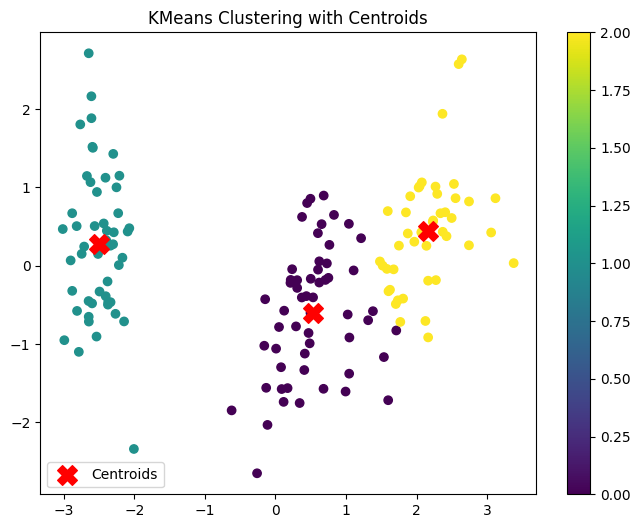

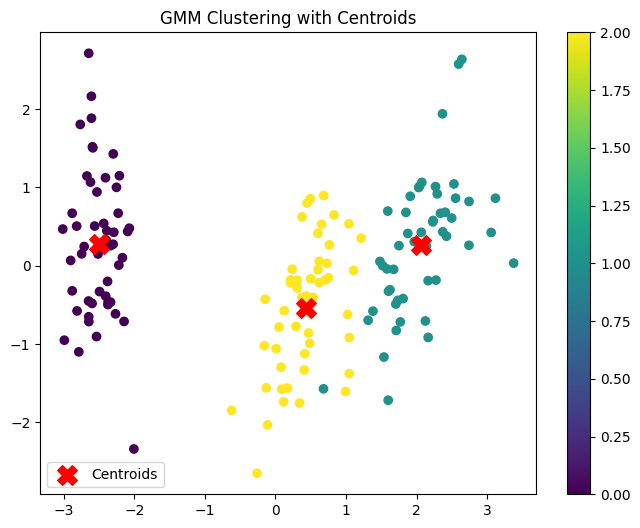

In [17]:
# 聚类中心可视化（仅适用于KMeans和GMM）
def plot_centroids(X, labels, centroids, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    centroids_2d = pca.transform(centroids)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.title(title)
    plt.colorbar(scatter)
    plt.legend()
    plt.show()

# KMeans和GMM的聚类中心可视化
plot_centroids(X_scaled, kmeans_labels, kmeans_model.get_centroids(), 'KMeans Clustering with Centroids')
plot_centroids(X_scaled, gmm_labels, gmm_model.means_, 'GMM Clustering with Centroids')

- `plot_centroids()` 可视化聚类结果，并标出聚类中心点。
- 对 KMeans 和 GMM 进行聚类中心可视化。

## 11. 打印评价指标

In [18]:
# 打印评价指标
print("KMeans Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_kmeans))
print("GMM Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_gmm))
print("DBSCAN Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_dbscan))

KMeans Evaluation Metrics: Silhouette = 0.456, NMI = 0.886, ARI = 0.886
GMM Evaluation Metrics: Silhouette = 0.442, NMI = 1.000, ARI = 1.000
DBSCAN Evaluation Metrics: Silhouette = -0.171, NMI = 0.380, ARI = 0.139


## 12. 聚类方法性能比较

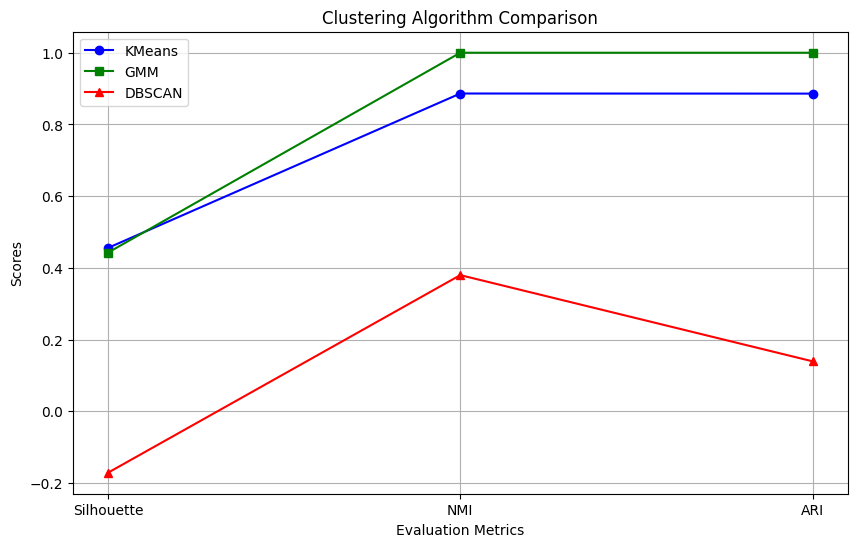

In [19]:
# 9. 比较不同方法的评价指标折线图
labels = ['Silhouette', 'NMI', 'ARI']
kmeans_scores = metrics_kmeans
gmm_scores = metrics_gmm
dbscan_scores = metrics_dbscan

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(labels, kmeans_scores, marker='o', label='KMeans', color='b')
plt.plot(labels, gmm_scores, marker='s', label='GMM', color='g')
plt.plot(labels, dbscan_scores, marker='^', label='DBSCAN', color='r')
plt.title('Clustering Algorithm Comparison')
plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

## 结果分析

### 1. **轮廓系数**

- **KMeans**: 轮廓系数 = 0.456
- **GMM**: 轮廓系数 = 0.442
- **DBSCAN**: 轮廓系数 = -0.171

**分析**:
- 轮廓系数的取值范围是 [-1, 1]，其中 1 表示聚类非常好，0 表示聚类重叠或分离不明显，-1 表示聚类结果非常差。
- **KMeans** 和 **GMM** 的轮廓系数较接近，都接近 0.45，表明聚类结果具有一定的分离性，但仍有一些混叠或噪声。
- **DBSCAN** 的轮廓系数为负，意味着它的聚类效果非常差。可能是由于DBSCAN聚类结果中很多样本被标记为噪声（标签为-1），导致其聚类不理想。

### 2. **NMI**

- **KMeans**: NMI = 0.886
- **GMM**: NMI = 1.000
- **DBSCAN**: NMI = 0.380

**分析**:
- **NMI** 衡量的是聚类标签与真实标签之间的一致性。它的取值范围是 [0, 1]，1表示完美匹配，0表示没有任何信息共享。
- **GMM** 得到的 NMI 为 1，表明其聚类标签与真实标签完全一致。这意味着 GMM 聚类成功地找出了数据的真实结构。
- **KMeans** 的 NMI 也很高，接近 0.886，表示它能很好地捕捉数据的聚类结构，尽管它不如 GMM 完全匹配。
- **DBSCAN** 的 NMI 较低，只有 0.380，表明它与真实标签的匹配较差，可能是因为 DBSCAN 将许多样本标记为噪声，导致聚类标签不准确。

### 3. **ARI**

- **KMeans**: ARI = 0.886
- **GMM**: ARI = 1.000
- **DBSCAN**: ARI = 0.139

**分析**:
- **ARI** 衡量的是聚类结果与真实标签之间的相似性，范围是 [-1, 1]，1表示完全一致，0表示与随机标签一致，负值表示聚类结果与真实标签相反。
- **GMM** 的 ARI 为 1，表示其聚类与真实标签完全一致，说明 GMM 完美地找到了数据的潜在结构。
- **KMeans** 的 ARI 为 0.886，表现也很好，接近 GMM，表明 KMeans 聚类结果与真实标签也很接近。
- **DBSCAN** 的 ARI 只有 0.139，表明它的聚类结果与真实标签之间的相似度较低，尤其是因为 DBSCAN 会将很多点标记为噪声（标签为-1）。

### 综合分析：
- **GMM** (高斯混合模型) 是最优秀的聚类方法，具有 **最高的 NMI** 和 **ARI**，表明它能够最好地捕捉数据的真实聚类结构。
- **KMeans** 的表现也非常好，虽然它的 **轮廓系数** 稍低于 GMM，但其 **NMI** 和 **ARI** 都很接近 GMM，表明它能够有效地将样本聚类在一起。
- **DBSCAN** 的表现较差，特别是它的 **轮廓系数** 和 **ARI** 较低，说明它可能未能很好地找到数据的结构，尤其是在数据中存在噪声时。DBSCAN 通常对于噪声较多的场景表现不好。

### 结论：
- **最佳聚类方法**：**GMM**，因为它在所有评价指标中表现最好，尤其是在 NMI 和 ARI 上取得了完美的得分。
- **次优方法**：**KMeans**，它的表现也非常好，尤其是在较为标准的数据集上，与 GMM 相差不大。
- **最差方法**：**DBSCAN**，由于其较差的轮廓系数和较低的 NMI 和 ARI，表明它在这个数据集上无法很好地进行聚类，可能是由于噪声点的影响。

## 完整代码

Converged after 9 iterations


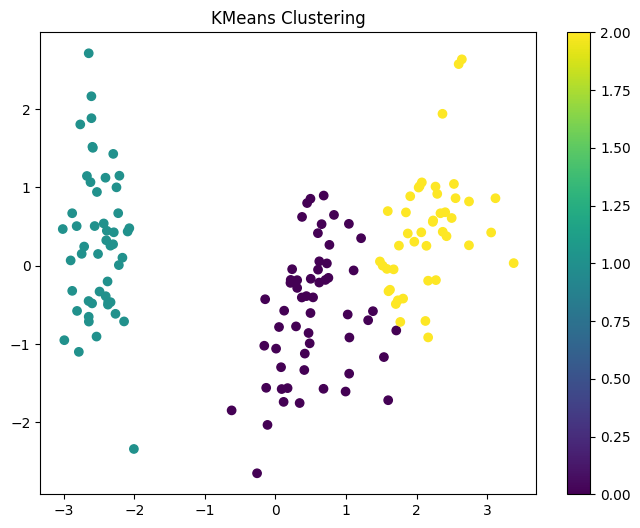

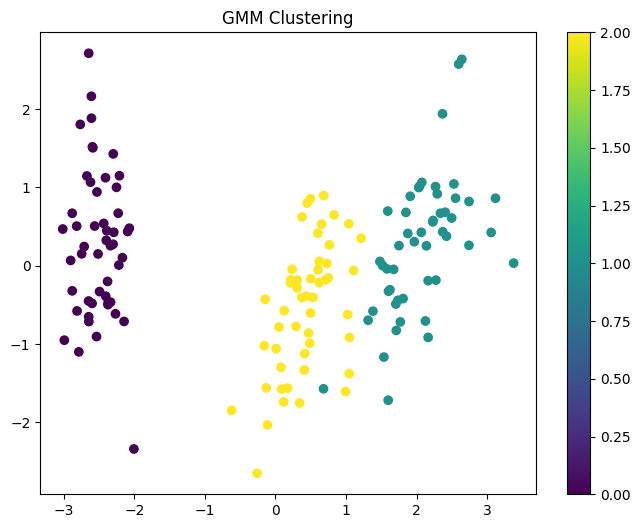

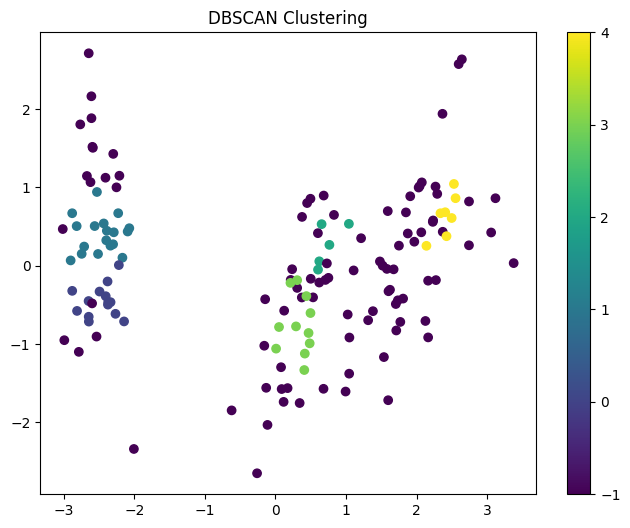

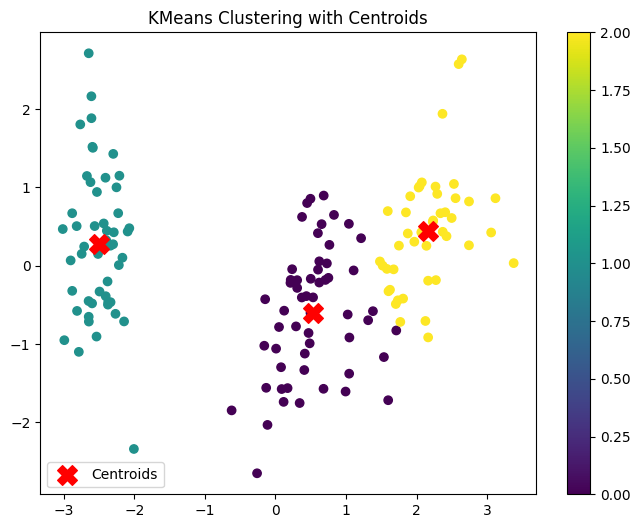

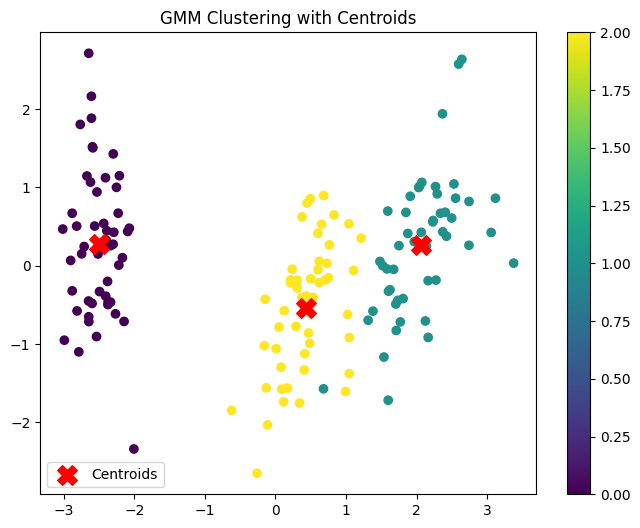

KMeans Evaluation Metrics: Silhouette = 0.456, NMI = 0.886, ARI = 0.886
GMM Evaluation Metrics: Silhouette = 0.442, NMI = 1.000, ARI = 1.000
DBSCAN Evaluation Metrics: Silhouette = -0.171, NMI = 0.380, ARI = 0.139


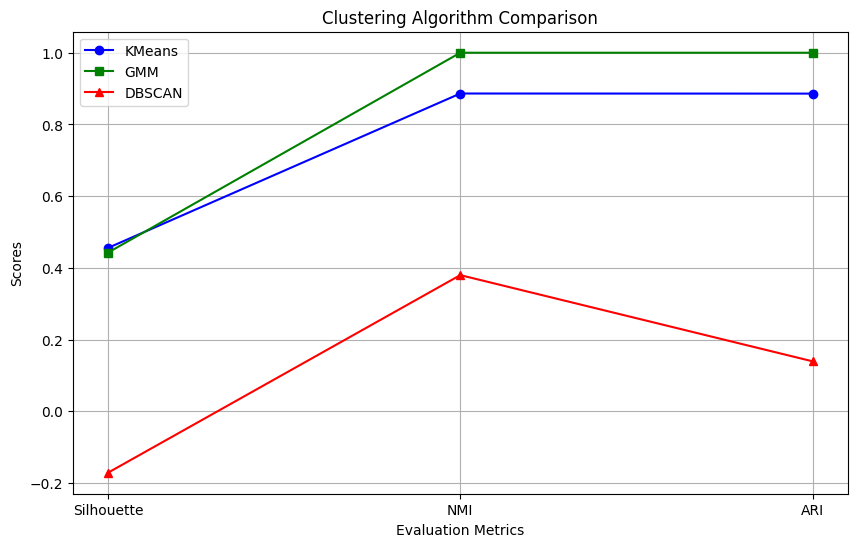

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.decomposition import PCA

# 1. 加载Iris数据集
file_path = '/home/aistudio/dataset/01-True/Iris.csv'
data = pd.read_csv(file_path)

# 查看数据集的结构
X = data.iloc[:, :-1].values  # 特征部分
y = data.iloc[:, -1].values  # 标签部分（Iris种类）

# 2. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. KMeans聚类
class KMeans:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
    
    def fit(self, X):
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[random_indices]
        
        for i in range(self.max_iters):
            labels = self._assign_labels(X)
            new_centroids = self._compute_centroids(X, labels)
            shift = np.sum((new_centroids - self.centroids) ** 2)
            if shift < self.tol:
                print(f'Converged after {i+1} iterations')
                break
            self.centroids = new_centroids
    
    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _compute_centroids(self, X, labels):
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
        return centroids
    
    def predict(self, X):
        return self._assign_labels(X)
    
    def get_centroids(self):
        return self.centroids

# 4. GMM聚类
def initialize_gmm(X, k):
    n_samples, n_features = X.shape
    kmeans = SklearnKMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X)
    means = kmeans.cluster_centers_
    covariances = np.array([np.eye(n_features)] * k)
    weights = np.ones(k) / k
    return means, covariances, weights

# 5. DBSCAN聚类
class DBSCAN:
    def __init__(self, epsilon=0.5, min_points=5):
        self.epsilon = epsilon
        self.min_points = min_points
        self.labels_ = None
    
    def fit(self, X):
        n_samples = len(X)
        self.labels_ = np.full(n_samples, -1)
        cluster_id = 0
        visited = np.zeros(n_samples, dtype=bool)
        
        def region_query(i):
            neighbors = []
            for j in range(n_samples):
                if np.linalg.norm(X[i] - X[j]) < self.epsilon:
                    neighbors.append(j)
            return neighbors
        
        def expand_cluster(i, neighbors, cluster_id):
            self.labels_[i] = cluster_id
            queue = neighbors[:]
            while queue:
                j = queue.pop(0)
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= self.min_points:
                        queue.extend(new_neighbors)
                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id
        
        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = region_query(i)
                if len(neighbors) < self.min_points:
                    self.labels_[i] = -1
                else:
                    expand_cluster(i, neighbors, cluster_id)
                    cluster_id += 1

# 6. 聚类算法比较
k = 3  # 选择3个簇
# KMeans
kmeans_model = KMeans(k=k)
kmeans_model.fit(X_scaled)
kmeans_labels = kmeans_model.predict(X_scaled)

# GMM
gmm_model = SklearnGMM(n_components=k)
gmm_labels = gmm_model.fit_predict(X_scaled)

# DBSCAN
dbscan_model = SklearnDBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_scaled)

# 7. 计算评价指标
def evaluate_clustering(true_labels, pred_labels):
    silhouette = silhouette_score(X_scaled, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return silhouette, nmi, ari

# 计算每个聚类方法的评价指标
metrics_kmeans = evaluate_clustering(y, kmeans_labels)
metrics_gmm = evaluate_clustering(y, gmm_labels)
metrics_dbscan = evaluate_clustering(y, dbscan_labels)

# 8. 可视化
def plot_clustering(X, labels, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()

# 聚类结果可视化
plot_clustering(X_scaled, kmeans_labels, 'KMeans Clustering')
plot_clustering(X_scaled, gmm_labels, 'GMM Clustering')
plot_clustering(X_scaled, dbscan_labels, 'DBSCAN Clustering')

# 聚类中心可视化（仅适用于KMeans和GMM）
def plot_centroids(X, labels, centroids, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    centroids_2d = pca.transform(centroids)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.title(title)
    plt.colorbar(scatter)
    plt.legend()
    plt.show()

# KMeans和GMM的聚类中心可视化
plot_centroids(X_scaled, kmeans_labels, kmeans_model.get_centroids(), 'KMeans Clustering with Centroids')
plot_centroids(X_scaled, gmm_labels, gmm_model.means_, 'GMM Clustering with Centroids')

# 打印评价指标
print("KMeans Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_kmeans))
print("GMM Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_gmm))
print("DBSCAN Evaluation Metrics: Silhouette = {:.3f}, NMI = {:.3f}, ARI = {:.3f}".format(*metrics_dbscan))

# 9. 比较不同方法的评价指标折线图
labels = ['Silhouette', 'NMI', 'ARI']
kmeans_scores = metrics_kmeans
gmm_scores = metrics_gmm
dbscan_scores = metrics_dbscan

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(labels, kmeans_scores, marker='o', label='KMeans', color='b')
plt.plot(labels, gmm_scores, marker='s', label='GMM', color='g')
plt.plot(labels, dbscan_scores, marker='^', label='DBSCAN', color='r')
plt.title('Clustering Algorithm Comparison')
plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()
